In [1]:
!ls /mnt/data/Train/

Alpha  Composition_code.py  FG	training_bg_names.txt  training_fg_names.txt


In [2]:
#!pip3 install scipy

In [3]:
import torch
from src.models.modnet import MODNet
from src.trainer import supervised_training_iter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import cv2
from skimage import morphology
from scipy.ndimage import distance_transform_edt
import torch.nn.functional as F
import torch
from PIL import Image, ImageOps
import pandas as pd
from pathlib import Path
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

In [4]:


# Set the base path for the dataset
base_path = Path("/mnt/data/Train/")

# Correcting the approach to construct the DataFrame without using 'append' in a loop

# Re-list the FG and Alpha images in case there was an issue with the initial listing
fg_images = list((base_path / "FG").rglob("*.*"))
alpha_images = list((base_path / "Alpha").rglob("*.*"))

# Initialize lists for holding the matched file paths
fg_file_paths = []
alpha_file_paths = []

# Map of alpha files for quick lookup by name
alpha_files_map = {alpha_image.name: alpha_image for alpha_image in alpha_images}

# Iterate over FG images and find corresponding Alpha images by name
for fg_image_path in fg_images:
    file_name = fg_image_path.name
    if file_name in alpha_files_map:
        # If the corresponding Alpha file is found, add both paths to the lists
        fg_file_paths.append(str(fg_image_path))
        alpha_file_paths.append(str(alpha_files_map[file_name]))

# Create the DataFrame directly from the lists of file paths
df_files_corrected = pd.DataFrame({
    "FG": fg_file_paths,
    "Alpha": alpha_file_paths
})

df_files_corrected.head()



,FG,Alpha
0,/mnt/data/Train/FG/0000.png,/mnt/data/Train/Alpha/0000.png
1,/mnt/data/Train/FG/0001.png,/mnt/data/Train/Alpha/0001.png
2,/mnt/data/Train/FG/0002.png,/mnt/data/Train/Alpha/0002.png
3,/mnt/data/Train/FG/0003.png,/mnt/data/Train/Alpha/0003.png
4,/mnt/data/Train/FG/0004.png,/mnt/data/Train/Alpha/0004.png


In [5]:
def group_images_by_size(annotations_df):
    # 创建一个字典来存储不同尺寸的图片路径
    size_to_paths = {}

    # 遍历DataFrame中的每一行
    for index, row in annotations_df.iterrows():
        img_path = row[0]  # 第一列是原图文件的位置
        # 获取图片尺寸
        with Image.open(img_path) as img:
            size = img.size

        # 将具有相同尺寸的图片路径分组
        if size not in size_to_paths:
            size_to_paths[size] = [index]
        else:
            size_to_paths[size].append(index)

    # 根据分组创建新的DataFrame列表
    grouped_annotations_files = []
    for indices in size_to_paths.values():
        grouped_df = annotations_df.iloc[indices]
        grouped_annotations_files.append(grouped_df)

    return grouped_annotations_files


In [6]:
file_size = group_images_by_size(df_files_corrected)
file_size[0].shape

/tmp/ipykernel_2143/3933085751.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]  # 第一列是原图文件的位置


(207, 2)

In [26]:
file_size[1]

,FG,Alpha
1,/mnt/data/Train/FG/0001.png,/mnt/data/Train/Alpha/0001.png
2,/mnt/data/Train/FG/0002.png,/mnt/data/Train/Alpha/0002.png
3,/mnt/data/Train/FG/0003.png,/mnt/data/Train/Alpha/0003.png
4,/mnt/data/Train/FG/0004.png,/mnt/data/Train/Alpha/0004.png
5,/mnt/data/Train/FG/0005.png,/mnt/data/Train/Alpha/0005.png
...,...,...
1158,/mnt/data/Train/FG/H_293.png,/mnt/data/Train/Alpha/H_293.png
1234,/mnt/data/Train/FG/H_372.png,/mnt/data/Train/Alpha/H_372.png
1267,/mnt/data/Train/FG/H_414.png,/mnt/data/Train/Alpha/H_414.png
1299,/mnt/data/Train/FG/H_451.png,/mnt/data/Train/Alpha/H_451.png


In [8]:
class OriginModNetDataLoader(Dataset):
    def __init__(self, annotations_file, resize_dim, transform=None):
        self.img_labels =annotations_file
        self.transform=transform
        self.resize_dim=resize_dim

    def __len__(self):
        #return the total number of images
        return len(self.img_labels)

    def __getitem__(self, idx):
        #print(idx)
        img_path = self.img_labels.iloc[idx,0]
        mask_path = self.img_labels.iloc[idx,1]
        #print(img_path,mask_path)
        temp_image = Image.open(img_path)
        #temp_image.show()
        img = np.asarray(temp_image)
        #display(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        #stupid = Image.open(mask_path)
        #stupid.show()
        #print(img.shape)
        #print(in_image.shape)
        #mask = in_image[:,:,3]
        

        if len(img.shape)==2:
            img = img[:,:,None]
        if img.shape[2]==1:
            img = np.repeat(img, 3, axis=2)
        elif img.shape[2]==4:
            img = img[:,:,0:3]

        if len(mask.shape)==3:
            mask = mask[:,:, 0]

        #convert Image to pytorch tensor
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)
        if self.transform:
            img = self.transform(img)
            trimap = self.get_trimap(mask)
            mask = self.transform(mask)

        img = self._resize(img)
        mask = self._resize(mask)
        trimap = self._resize(trimap, trimap=True)

        img = torch.squeeze(img, 0)
        mask = torch.squeeze(mask, 0)
        trimap = torch.squeeze(trimap, 1)
        #print(img.shape,trimap.shape,mask.shape)
        return img.cuda(), trimap.cuda(), mask.cuda()

    def get_trimap(self, alpha):
        # alpha \in [0, 1] should be taken into account
        # be careful when dealing with regions of alpha=0 and alpha=1
        fg = np.array(np.equal(alpha, 255).astype(np.float32))
        unknown = np.array(np.not_equal(alpha, 0).astype(np.float32)) # unknown = alpha > 0
        unknown = unknown - fg
        # image dilation implemented by Euclidean distance transform
        unknown = distance_transform_edt(unknown==0) <= np.random.randint(1, 20)
        trimap = fg
        trimap[unknown] = 0.5
        return torch.unsqueeze(torch.from_numpy(trimap), dim=0)#.astype(np.uint8)

    def ori_resize(self, img, trimap=False):
        im = img[None, :, :, :]
        ref_size = self.resize_dim

        # resize image for input
        im_b, im_c, im_h, im_w = im.shape
        if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
            if im_w >= im_h:
                im_rh = ref_size
                im_rw = int(im_w / im_h * ref_size)
            elif im_w < im_h:
                im_rw = ref_size
                im_rh = int(im_h / im_w * ref_size)
        else:
            im_rh = im_h
            im_rw = im_w

        im_rw = im_rw - im_rw % 32
        im_rh = im_rh - im_rh % 32
        im_rw=512
        im_rh=512
        if trimap == True:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='nearest')
        else:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='area')
        #imb =transforms.ToPILImage()(im.squeeze().cpu())
        #imb.show()
        return im
    def _resize(self, img, trimap=False):
        im = img[None, :, :, :]
        ref_size = self.resize_dim

    # 计算调整后的图片尺寸
        im_b, im_c, im_h, im_w = im.shape
        if im_h > 1024 or im_w > 1024:
            scale_factor = 0.5  # 如果任一边大于1024，则缩放因子为0.5
        else:
            scale_factor = min(ref_size / max(im_h, im_w), ref_size / min(im_h, im_w))
    
        im_rh = int(im_h * scale_factor)
        im_rw = int(im_w * scale_factor)

        # 确保尺寸能被32整除
        im_rh = im_rh + (32 - im_rh % 32) if im_rh % 32 != 0 else im_rh
        im_rw = im_rw + (32 - im_rw % 32) if im_rw % 32 != 0 else im_rw

        # 根据是否是trimap选择插值方法
        if trimap:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='nearest')
        else:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='area')

        return im


In [9]:
class ImageMatteLoader:
    def __init__(self, annotations_file):
        self.annotations_file = annotations_file
    
    def __len__(self):
        # 返回DataFrame的长度，即图像对的数量
        return len(self.annotations_file)
    
    def __getitem__(self, idx):
        # 根据索引idx获取对应的原图和matte图像的路径
        img_path = self.annotations_file.iloc[idx, 0]
        matte_path = self.annotations_file.iloc[idx, 1]
        
        # 加载原图和matte图像
        image = Image.open(img_path)
        matte = Image.open(matte_path)
        
        return image, matte

    def show(self, idx):
        # 根据索引idx获取对应的原图和matte图像
        image, matte = self.__getitem__(idx)
        
        # 合并原图和matte
        combined = self.combined_display(image, matte)
        
        # 显示合并后的图像
        combined.show()

    def combined_display(self, image, matte):
        # 计算显示分辨率
        w, h = image.width, image.height
        rw, rh = 800, int(h * 800 / (3 * w))
        
        # 获取预测的前景
        image = np.asarray(image)
        if len(image.shape) == 2:
            image = image[:, :, None]
        if image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)
        elif image.shape[2] == 4:
            image = image[:, :, 0:3]
        matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
        foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
        
        # 将原图、前景、和alpha通道合并为一行
        combined = np.concatenate((image, foreground, matte * 255), axis=1)
        combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
        return combined



In [10]:
#train_data = ModNetDataLoader(df_files_corrected,1080,True)
transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)
            )
        ]
    )
data = OriginModNetDataLoader(file_size[1], 512, transform=transformer)
raw_data = ImageMatteLoader(file_size[1])

In [24]:
raw_data[5]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2350x1567>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=2350x1567>)

In [12]:


class ModNetImageGenerator(Dataset):
    def __init__(self, annotations_file, modnet, transform=None):
        self.img_paths = annotations_file
        self.modnet = modnet
        self.transform = transform
        self.modnet.eval()  # 确保MODNet处于评估模式
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        
        # 调整图像尺寸使其符合模型要求
        original_size = image.size
        adjusted_size = [((dim + 31) // 32) * 32 for dim in original_size]  # 使尺寸成为32的倍数
        image = image.resize(adjusted_size, Image.Resampling.LANCZOS)
        
        # 如果有额外的图像预处理步骤
        if self.transform:
            transformed_img = self.transform(image)
        else:
            # 默认的图像预处理
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            transformed_img = transform(image)
        
        # 使用MODNet预测matte
        with torch.no_grad():
            matte_tensor = self.modnet(transformed_img.unsqueeze(0).cuda(),False)[2]
        
        # 调整matte尺寸回原始尺寸
        matte = transforms.functional.to_pil_image(matte_tensor.squeeze(0))
        matte = matte.resize(original_size, Image.Resampling.LANCZOS)
        
        return image.resize(original_size, Image.Resampling.LANCZOS), matte
    
    def show(self, idx):
        image, matte_img = self.__getitem__(idx)
        # 此处可以添加显示图像和matte的代码
        combined = self.combined_display(image, matte_img)
        combined.show()

    def combined_display(self, image, matte):
        #计算显示分辨率
        w, h = image.width, image.height
        rw, rh = 800, int(h * 800 / (3 * w))
        
        # 获取预测的前景
        image = np.asarray(image)
        if len(image.shape) == 2:
            image = image[:, :, None]
        if image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)
        elif image.shape[2] == 4:
            image = image[:, :, 0:3]
        matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
        foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
        
        # 将原图、前景、和alpha通道合并为一行
        combined = np.concatenate((image, foreground, matte * 255), axis=1)
        combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
        return combined


In [13]:
bs = 4         # batch size
lr = 0.01       # learn rate
epochs = 40     # total epochs
train_dataloader = DataLoader(data, batch_size=bs, shuffle=True)
modnet = torch.nn.DataParallel(MODNet()).cuda()
optimizer = torch.optim.SGD(modnet.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(0.25 * epochs), gamma=0.1)


#dataloader = train-datalo(bs)     # NOTE: please finish this function

#for epoch in range(0, epochs):
#    for idx, (image, trimap, gt_matte) in enumerate(train_dataloader):
#        semantic_loss, detail_loss, matte_loss = \
#            supervised_training_iter(modnet, optimizer, image, trimap, gt_matte)
#        lr_scheduler.step()


writer = SummaryWriter('runs/MODNet')
update_freq = 100  # Update the plot every 100 iterations
for epoch in range(0, epochs):
    for idx, (image, trimap, gt_matte) in enumerate(train_dataloader):
        # Your training step
        semantic_loss, detail_loss, matte_loss = supervised_training_iter(modnet, optimizer, image, trimap, gt_matte)
        writer.add_scalar('semantic', semantic_loss, epoch)
        writer.add_scalar('detail_loss', detail_loss, epoch)
        writer.add_scalar('matte_loss', matte_loss, epoch)


#        if idx % update_freq == 0:
#            # Efficiently update the plot
#            ax.clear()
#            if len(semantic_losses) > 0:
#                ax.plot(semantic_losses, label='Semantic Loss')
#            if len(detail_losses) > 0:
#                ax.plot(detail_losses, label='Detail Loss')
#            if len(matte_losses) > 0:
#               ax.plot(matte_losses, label='Matte Loss')
#            
#            ax.legend()
#            plt.draw()
#            plt.pause(0.1)  # A slightly longer pause to ensure the GUI has time to update

    lr_scheduler.step()

 # Turn off interactive mode when done to finalize the plot
torch.save(modnet.state_dict(), 'model_path.pth')



NameError: name 'model' is not defined

In [ ]:
#a,b,c=modnet(data[1][0].unsqueeze(0).cuda(),False)

In [16]:
test = ModNetImageGenerator(file_size[1],modnet)

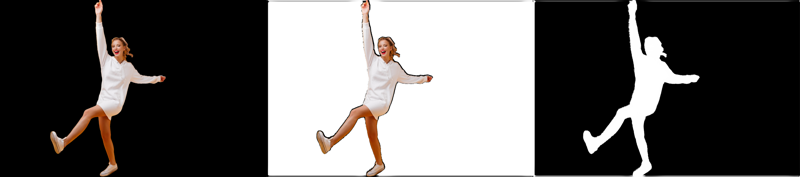

In [27]:
test.show(1)

In [21]:
hi=ImageMatteLoader(file_size[1])

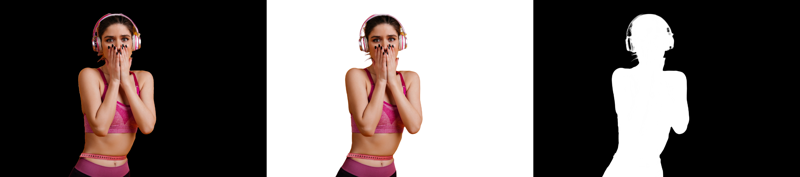

In [22]:
hi.show(5)